<a href="https://colab.research.google.com/github/gilsonauerswald/Bioinformatic_Projects/blob/main/TCGA_Lesson_5_N_integration_with_DIABLO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **N-integration with DIABLO**

N-Integration is the framework of having multiple datasets which measure different aspects of the same samples. For example, you may have transcriptomic, genetic and proteomic data for the same set of cells. N-integrative methods are built to use the information in all three of these dataframes simultaenously.

DIABLO is a novel mixOmics framework for the integration of multiple data sets while explaining their relationship with a categorical outcome variable. DIABLO stands for Data Integration Analysis for Biomarker discovery using Latent variable approaches for Omics studies. It can also be referred to as Multiblock (s)PLS-DA.

# **We First load mixOmics:**

In [ ]:
install.packages("BiocManager")
BiocManager::install("mixOmics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'BiocVersion', 'mixOmics'

also installing the dependencies ‘formatR’, ‘RcppEigen’, ‘lambda.r’, ‘futile.options’, ‘plyr’, ‘RSpectra’, ‘futile.logger’, ‘snow’, ‘BH’, ‘pracma’, ‘igraph’, ‘ellipse’, ‘corpcor’, ‘reshape2’, ‘matrixStats’, ‘rARPACK’, ‘gridExtra’, ‘ggrepel’, ‘BiocParallel’, ‘gsignal’, ‘rgl’


Old packages: 'broom', 'credentials', 'dbplyr', 'dtplyr', 'ggplot2',
  'googledrive', 'magrittr'



In [ ]:
# Load required libraries
library(mixOmics)
library(readr)
library(dplyr)
library(tibble)

Loading required package: MASS

Loading required package: lattice

Loading required package: ggplot2


Loaded mixOmics 6.32.0
Thank you for using mixOmics!
Tutorials: http://mixomics.org
Bookdown vignette: https://mixomicsteam.github.io/Bookdown
Questions, issues: Follow the prompts at http://mixomics.org/contact-us
Cite us:  citation('mixOmics')



Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# **Load Data**

In [ ]:
# Load datasets
miRNA_data <- read_csv("https://raw.githubusercontent.com/Omicslogic-git/Project_3_data/refs/heads/main/Final_Train_miRNA_tpose.csv")
gene_data <- read_csv("https://raw.githubusercontent.com/Omicslogic-git/Project_3_data/refs/heads/main/Final_Train_RNA-tpose.csv")
metadata <- read_csv("https://raw.githubusercontent.com/Omicslogic-git/Project_3_data/refs/heads/main/TCGA_META_DATA.csv")

miRNA_data <- data.frame(miRNA_data)
gene_data <- data.frame(gene_data)

# Preprocess the data
# Assuming the first column is sample identifiers, we'll set them as rownames
miRNA_data <- miRNA_data %>%
  column_to_rownames(var = colnames(miRNA_data)[1])

gene_data <- gene_data %>%
  column_to_rownames(var = colnames(gene_data)[1])

miRNA_data <- t(miRNA_data)
gene_data <- t(gene_data)


# Display first few rows of the datasets
#head(miRNA_data)
#head(gene_data)
#head(metadata)

# Display column names of metadata to identify the correct sample identifier column
colnames(metadata)


# Scale the data
miRNA_data <- scale(miRNA_data)
gene_data <- scale(gene_data)

# Identify the correct column name for sample identifiers in metadata
# Assuming the sample identifier column is the first column
metadata <- metadata %>%
  column_to_rownames(var = colnames(metadata)[1])

unique(metadata$Condition)
metadata$Condition <- as.factor(metadata$Condition)
Y = metadata$Condition
summary(Y)

# Create a list of datasets
data <- list(miRNA = miRNA_data, gene = gene_data)

# check dimension
lapply(data, dim)

Rows: 1242 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): id
dbl (50): TCGA-DD-AACL_StageI, TCGA-WJ-A86L_StageI, TCGA-EP-A2KC_StageI, TCG...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8705 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): id
dbl (50): TCGA-DD-AACL_StageI, TCGA-WJ-A86L_StageI, TCGA-EP-A2KC_StageI, TCG...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 50 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): id, Condition

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FA

[1] "id"        "Condition"

[1] "StageI"   "StageII"  "StageIII" "StageIV"

StageI  StageII StageIII  StageIV 
      20       14       13        3

$miRNA
[1]   50 1242

$gene
[1]   50 8705

In [ ]:
# Assume rownames in miRNA_data & gene_data are sample IDs; same for metadata’s rownames.
common <- Reduce(intersect, list(rownames(miRNA_data), rownames(gene_data), rownames(metadata)))

miRNA_data <- miRNA_data[common, , drop = FALSE]
gene_data  <- gene_data [common, , drop = FALSE]

# Make sure features are numeric matrices
data <- list(
  miRNA = data.matrix(miRNA_data),
  gene  = data.matrix(gene_data)
)

# Factor response with matching order
Y <- factor(metadata[common, "Condition"])

# **Parameter choice**
Here we choose a design where all blocks (data sets) are connected with a link of 0.1.

In [ ]:
design = matrix(0.1, ncol = length(data), nrow = length(data),
                dimnames = list(names(data), names(data)))
diag(design) = 0
design

,miRNA,gene
miRNA,0.0,0.1
gene,0.1,0.0


First, we fit a DIABLO model without variable selection to assess the global performance and
choose the number of components for the final DIABLO model. The function perf is run with
3-fold cross validation repeated 10 times.

In [ ]:
library(mixOmics)
set.seed(123) # for reproducibility, only when the `cpus' argument is not used
# add near.zero.var=TRUE so constants/nzv features are dropped per block
sgccda.res <- block.splsda(
  X       = data,
  Y       = Y,
  ncomp   = 5,
  design  = design,
  near.zero.var = TRUE
)

# (Optional) run perf in serial to see cleaner errors while debugging
library(BiocParallel)
perf.diablo <- perf(
  sgccda.res,
  validation = "Mfold",
  folds = 3,
  nrepeat = 10,
  BPPARAM = SerialParam()   # or MulticoreParam(workers = 4) once it works
)

Design matrix has changed to include Y; each block will be
            linked to Y.



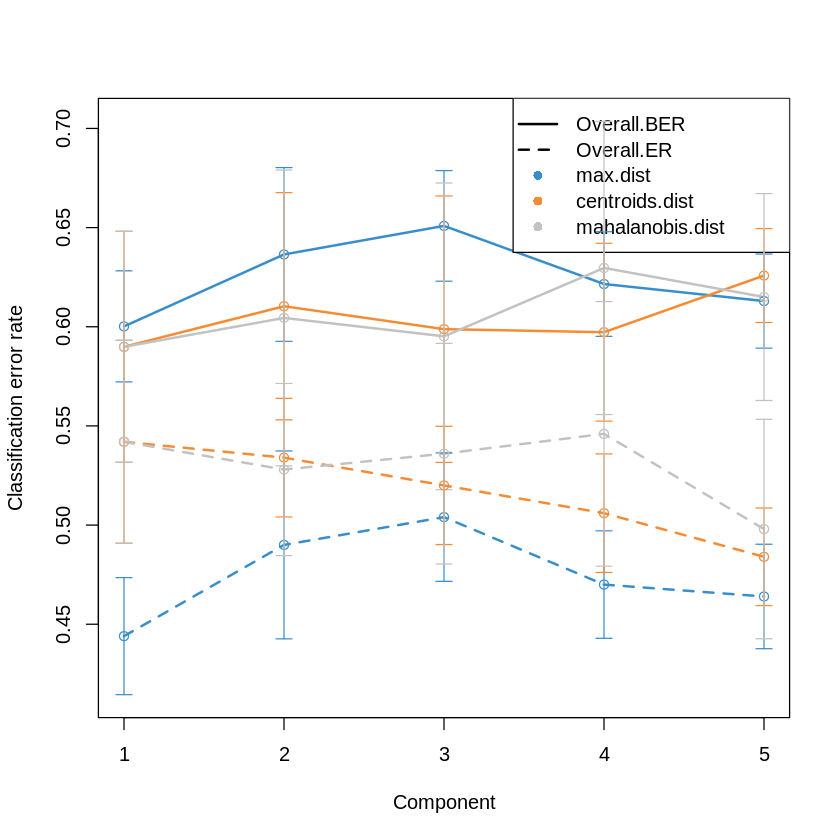

In [ ]:
#perf.diablo  # lists the different outputs
plot(perf.diablo)

Considering this distance and the BER, the output $choice.ncomp
indicates an optimal number of components = 2 for the final DIABLO model.

In [ ]:
perf.diablo$choice.ncomp$WeightedVote

,max.dist,centroids.dist,mahalanobis.dist
Overall.ER,1,5,1
Overall.BER,1,1,1


In [ ]:
ncomp = perf.diablo$choice.ncomp$WeightedVote["Overall.BER", "centroids.dist"]

Now that the number of components is chosen, the next step is to choose the optimal number
of variables to select in each data set using the tune.block.splsda function. We provide a grid
of keepX values for each type of `omics. Note that we set the grid to favour a small (but not too
small) signature while allowing to obtain a suficient number of variables for downstream validation
/ interpretation.

In [ ]:
ncomp

[1] 1

In [ ]:
# Install and load the BiocParallel package if not already installed
if (!requireNamespace("BiocParallel", quietly = TRUE)) {
    BiocManager::install("BiocParallel")
}
library(BiocParallel)

# Set up parallel backend with 2 cores
BPPARAM <-   SerialParam()   #MulticoreParam(workers = 2)

# Define the data and parameters
set.seed(123) # for reproducibility
test.keepX <- list(
  miRNA = c(5:9, seq(10, 18, 2), seq(20, 30, 5)),
  gene  = c(5:9, seq(10, 18, 2), seq(20, 30, 5))
)

# Measure time taken for tuning
t1 <- proc.time()
tune.TCGA <- tune.block.splsda(X = data, Y = Y, ncomp = 5,
                               test.keepX = test.keepX, design = design,
                               validation = 'Mfold', folds = 3, nrepeat = 1,
                               BPPARAM = BPPARAM, dist = "centroids.dist")
t2 <- proc.time()
running_time <- t2 - t1

# Output the running time
running_time

# Retrieve the optimal number of variables to keep for each block
list.keepX <- tune.TCGA$choice.keepX
list.keepX

Design matrix has changed to include Y; each block will be
            linked to Y.


You have provided a sequence of keepX of length: 13 for block miRNA and 13 for block gene.
This results in 169 models being fitted for each component and each nrepeat, this may take some time to run, be patient!


You can look into the 'BPPARAM' argument to speed up computation time.

Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning message:
“The SGCCA algorithm did not converge”
Warning mess

   user  system elapsed 
327.237   0.458 329.908 

$miRNA
[1]  5  9  5 10  6

$gene
[1] 20  6 20  6  9

The number of features to select on each component is returned in tune.TCGA$choice.keepX:

In [ ]:
list.keepX = tune.TCGA$choice.keepX
tune.TCGA$choice.keepX

$miRNA
[1]  5  9  5 10  6

$gene
[1] 20  6 20  6  9

# **Final model**
The final DIABLO model is run as:

In [ ]:
sgccda.res = block.splsda(X = data, Y = Y, ncomp = 5,
                          keepX = list.keepX, design = design, near.zero.var = TRUE)

Design matrix has changed to include Y; each block will be
            linked to Y.



The warning message informs that the outcome Y has been included automatically in the design,
so that the covariance between each block's component and the outcome is maximised, as shown in
the final design output:

In [ ]:
sgccda.res$design

,miRNA,gene,Y
miRNA,0.0,0.1,1
gene,0.1,0.0,1
Y,1.0,1.0,0


The selected variables can be extracted with the function selectVar, for example in the mRNA
block, along with their loading weights:

In [ ]:
# mRNA variables selected on component 1
selectVar(sgccda.res, block = 'gene', comp = 1)

,value.var
,<dbl>
MTCO1P27,-0.520429859
SNORD116-15,-0.297058501
RNU6-880P,-0.289489351
RNU6-103P,-0.283525727
RNA5SP399,-0.273728255
LINC01181,-0.259840295
PDZPH1P,-0.242861115
RNU6-795P,-0.225504718
RNA5SP297,-0.223046345


## **Sample plots**
plotDIABLO is a diagnostic plot to check whether the correlation between components from each
data set was maximised as specified in the design matrix. We specify the dimension to be assessed
with the ncomp argument.

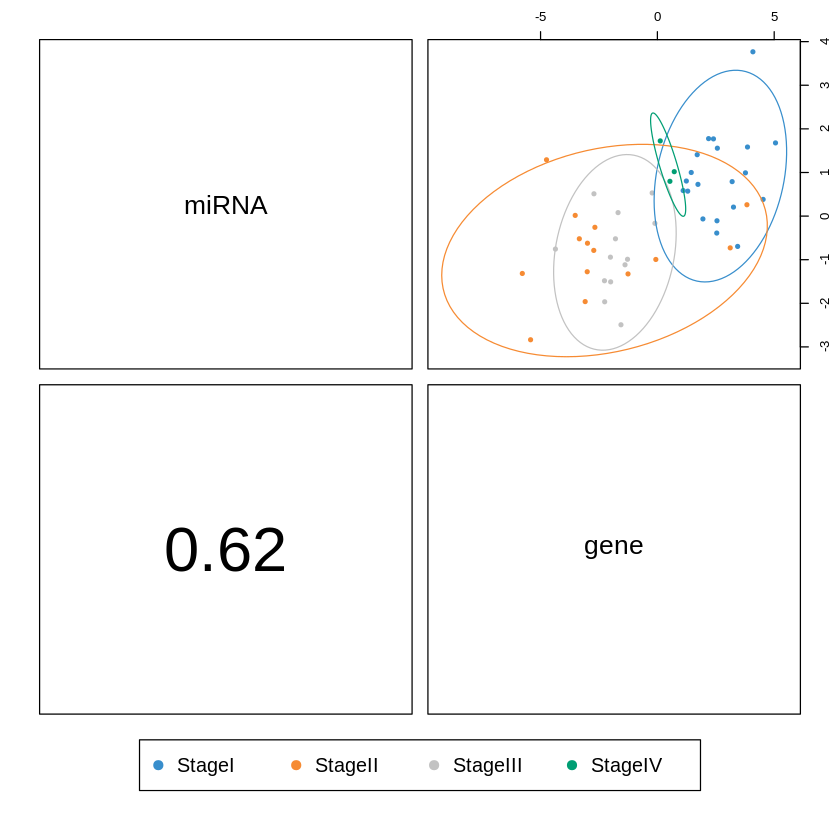

In [ ]:
plotDiablo(sgccda.res, ncomp = 1)

The sample plot with the plotIndiv function projects each sample into the space spanned by
the components from each block. The optional argument blocks can output a specific data set.
Ellipse plots are also available (argument ellipse = TRUE). This type of graphic allows us to better
understand the information extracted from each data set and its discriminative ability.

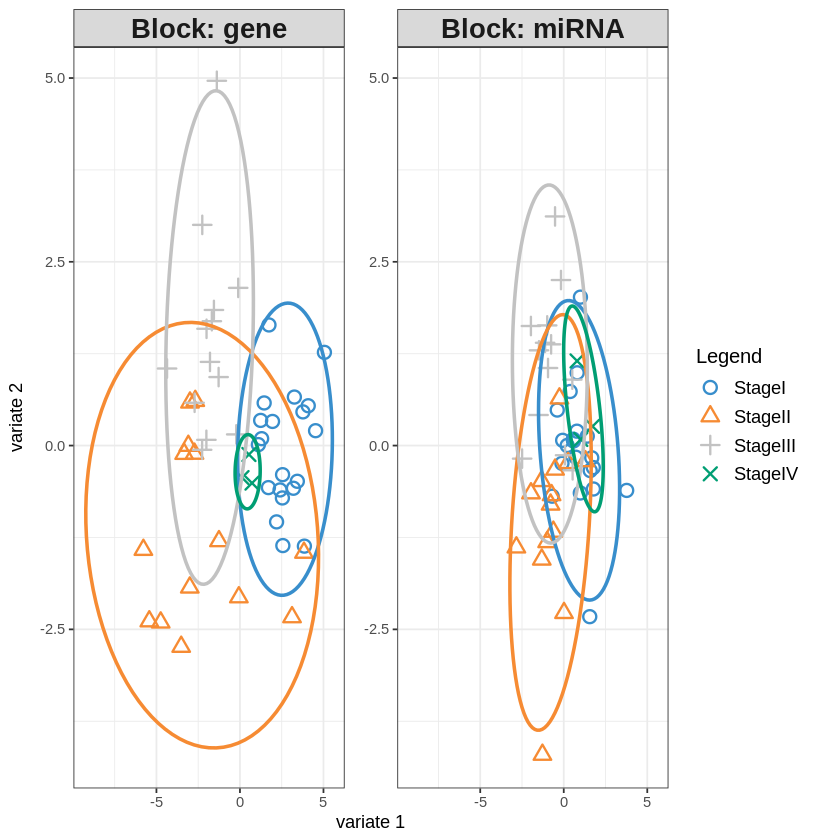

In [ ]:
plotIndiv(sgccda.res, ind.names = FALSE, legend = TRUE, ellipse = T, style="ggplot2")

In the arrow plot below, the start of the arrow indicates the centroid between all data sets for a
given sample and the tip of the arrow the location of the same sample in each block. Such graphic
highlights the agreement between all data sets at the sample level when modelled with DIABLO.

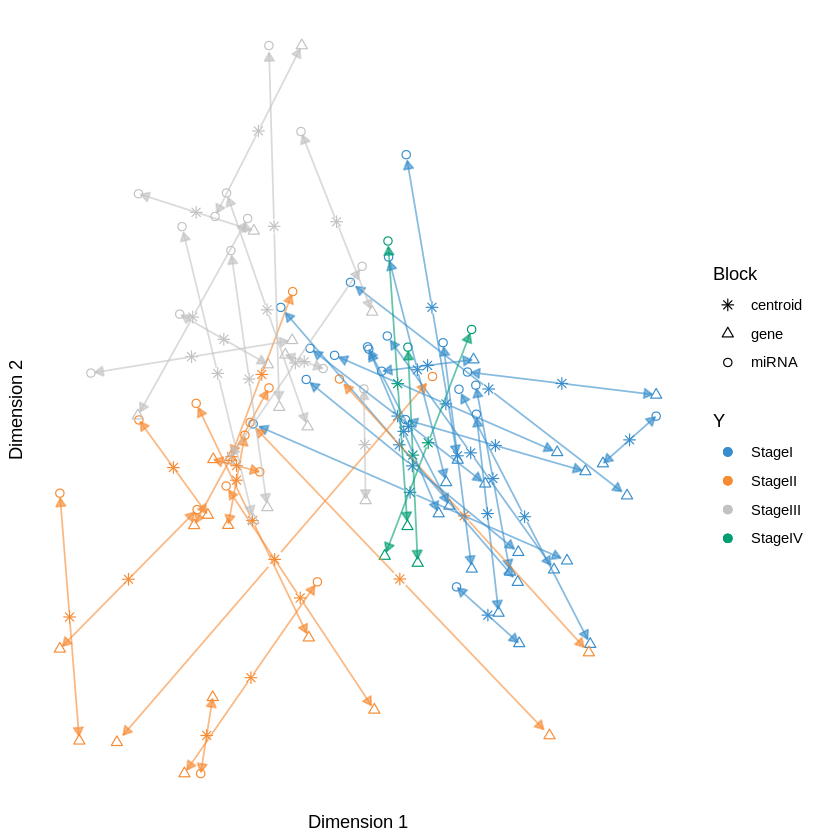

In [ ]:
plotArrow(sgccda.res, ind.names = FALSE, legend = TRUE, title = 'DIABLO')

## **Variable plots**
Several graphical outputs are available to visualise and mine the associations between the selected
variables.


The correlation circle plot highlights the contribution of each selected variable to each component.
Important variables should be close to the large circle, see Gonzalez et al. 2012 for more details.
plotVar displays the variables from all blocks, selected on component 1 and 2. Clusters of points
indicate a strong correlation between variables. For better visibility we choose to hide the variable
names.

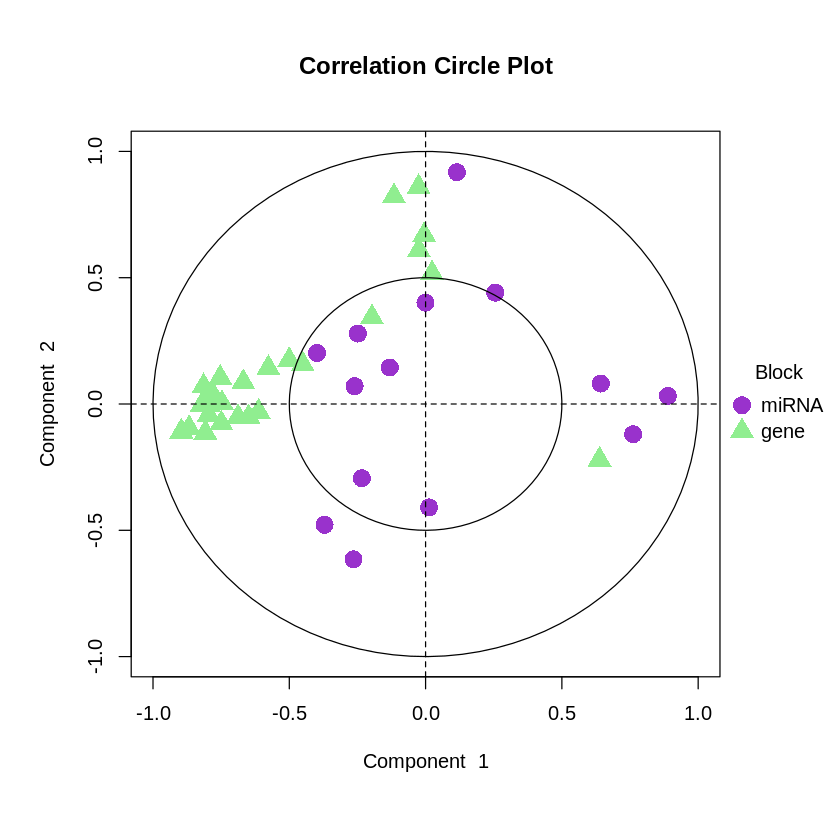

In [ ]:
plotVar(sgccda.res, var.names = FALSE, style = 'graphics', legend = TRUE,
        pch = c(16, 17), cex = c(2,2), col = c('darkorchid', 'lightgreen'))

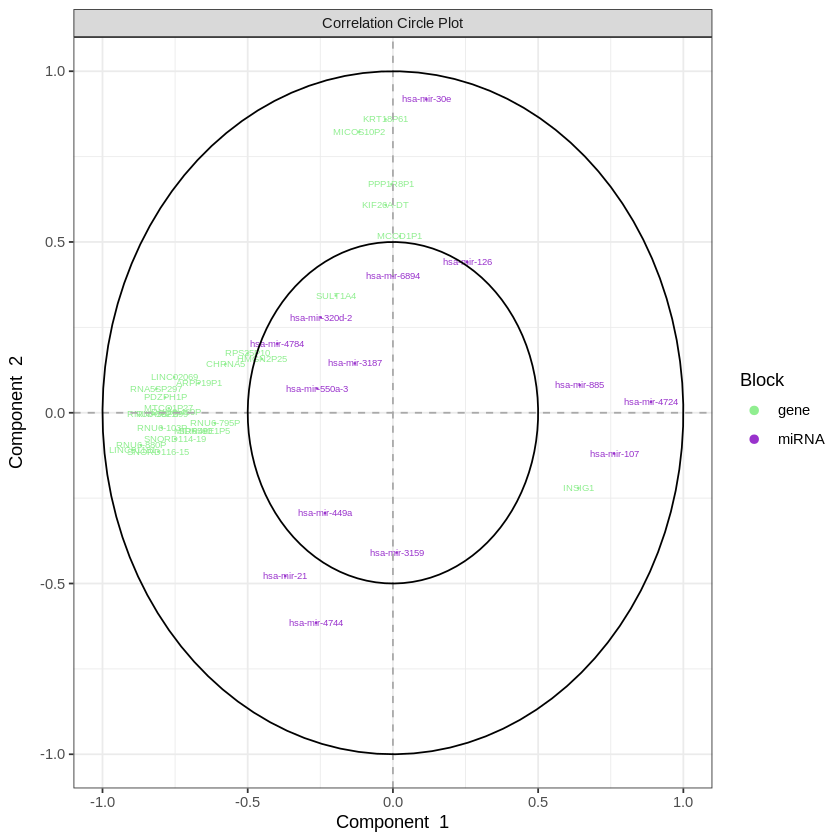

In [ ]:
plotVar(
  sgccda.res,
  var.names = TRUE,
  legend = TRUE,
  pch = c(16, 17),
  cex = c(2, 2),
  col = c("darkorchid", "lightgreen")
)
p <- ggplot2::last_plot()   # <- ensures we have a ggplot object

# save (filename first!)
ggplot2::ggsave(
  filename = "plotVar_diablo_comp1-2.png",
  plot = p,
  width = 8, height = 6, units = "in",
  dpi = 600, bg = "white")

We can also only display the variables selected on a specific component, here component 1:

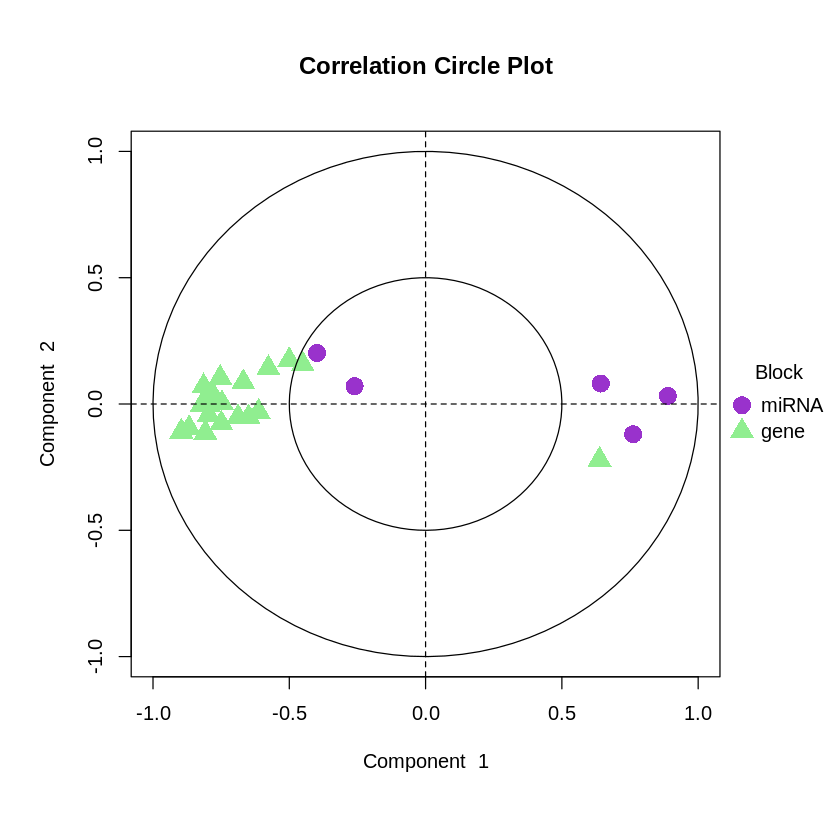

In [ ]:
plotVar(sgccda.res, var.names = FALSE, style = 'graphics', legend = TRUE,
        pch = c(16, 17), cex = c(2,2), col = c('darkorchid', 'lightgreen'),
        comp.select = 1)

The circos plot represents the correlations between variables of different types, represented on
the side quadrants. Several display options are possible, to show within and between connexions
between blocks, expression levels of each variable according to each class (argument line = TRUE).
The circos plot is built based on a similarity matrix, which was extended to the case of multiple
data sets from Gonzalez et al. 2012.

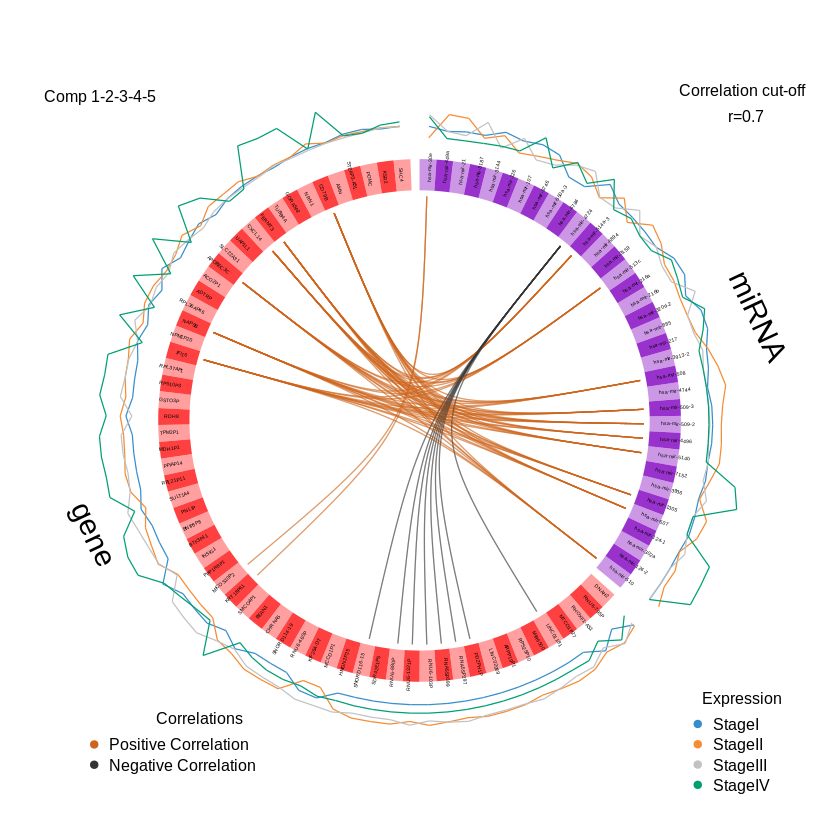

In [ ]:
circosPlot(sgccda.res, cutoff = 0.7, line = TRUE,
           color.blocks= c('darkorchid', 'brown1'),
           color.cor = c("chocolate3","grey20"), size.labels = 1.5)

Another visualisation of the correlation between the different types of variables is the relevance
network, which is also built on the similarity matrix. Each color represents a type of variable. A
threshold can also be set using the argument cutoff.

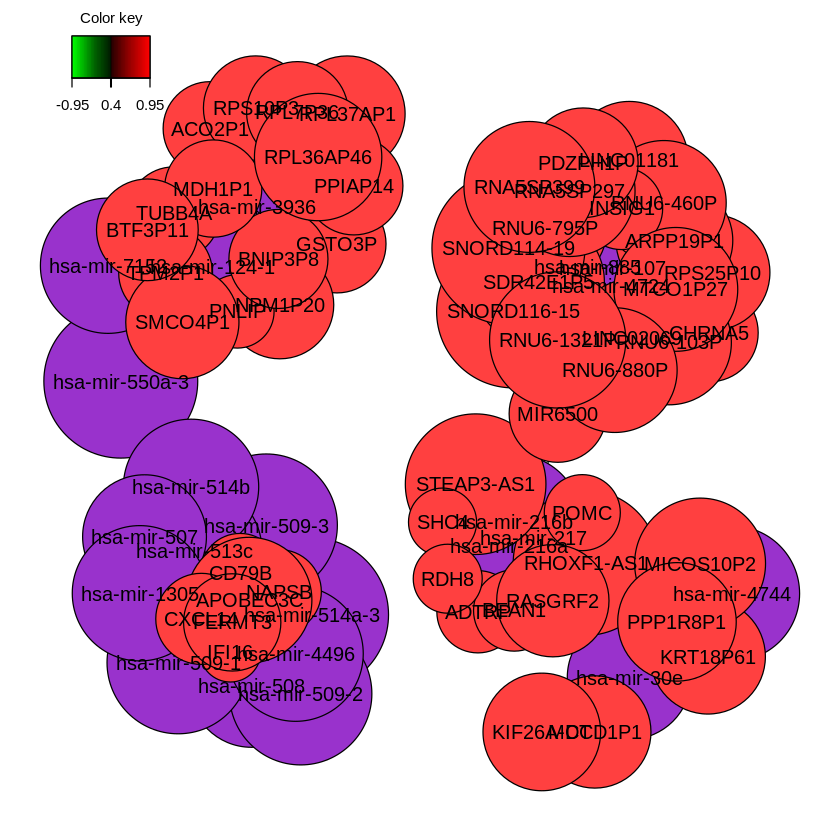

In [ ]:
network(sgccda.res, blocks = c(1,2),
        color.node = c('darkorchid', 'brown1'), cutoff = 0.4)

The network can be saved in a .gml format to be input into the software Cytoscape, using the R
package igraph.


Attaching package: ‘igraph’


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




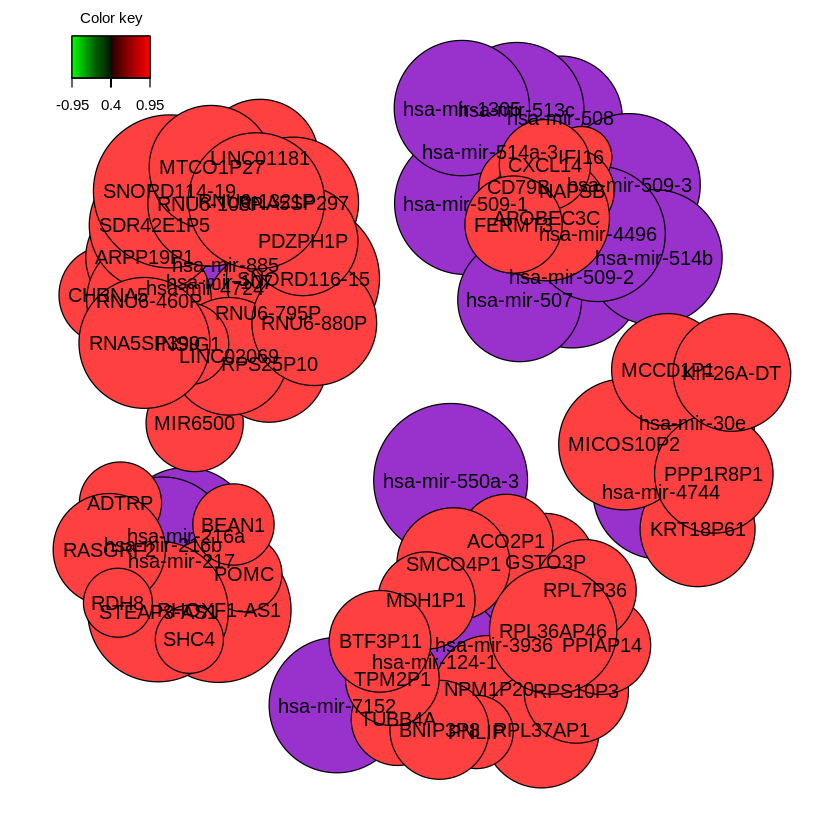

In [ ]:
library(igraph)
my.network = network(sgccda.res, blocks = c(1,2),
         color.node = c('darkorchid', 'brown1'), cutoff = 0.4)
write_graph(my.network$gR, file = "myNetwork.gml", format = "gml")

plotLoadings visualises the loading weights of each selected variables on each component and
each data set. The color indicates the class in which the variable has the maximum level of expression
(contrib = 'max') or minimum (contrib = `min'), on average (method = `mean') or using the
median (method = `median').

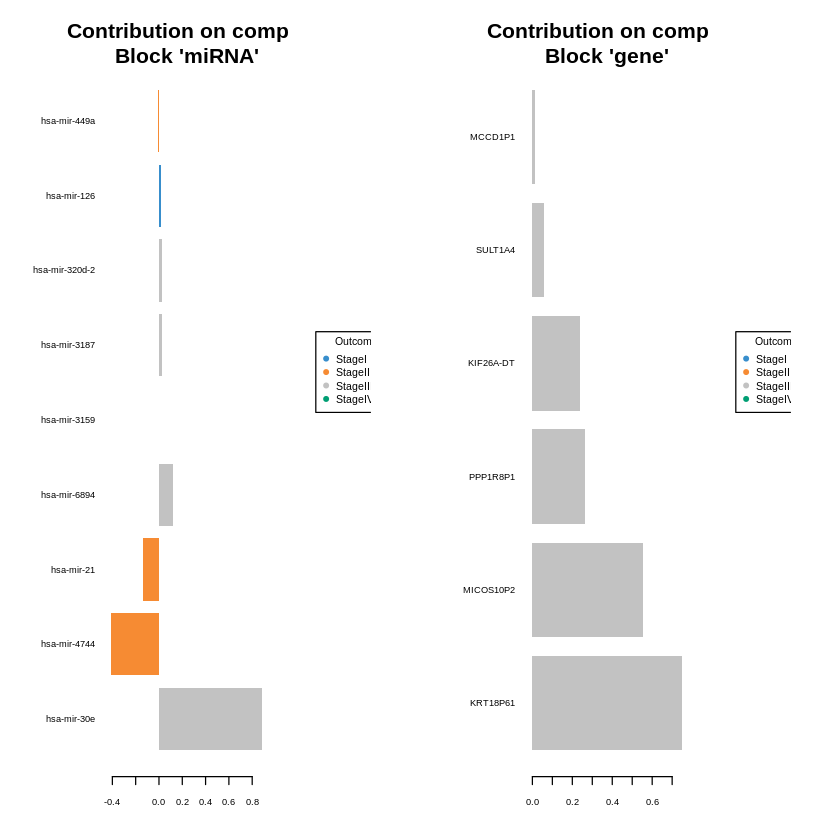

In [ ]:
plotLoadings(sgccda.res, comp = 2, contrib = 'max', method = 'median')

The cimDiablo function is a clustered image map specifically implemented to represent the
multi-`omics molecular signature expression for each sample.


trimming values to [-3, 3] range for cim visualisation. See 'trim' arg in ?cimDiablo


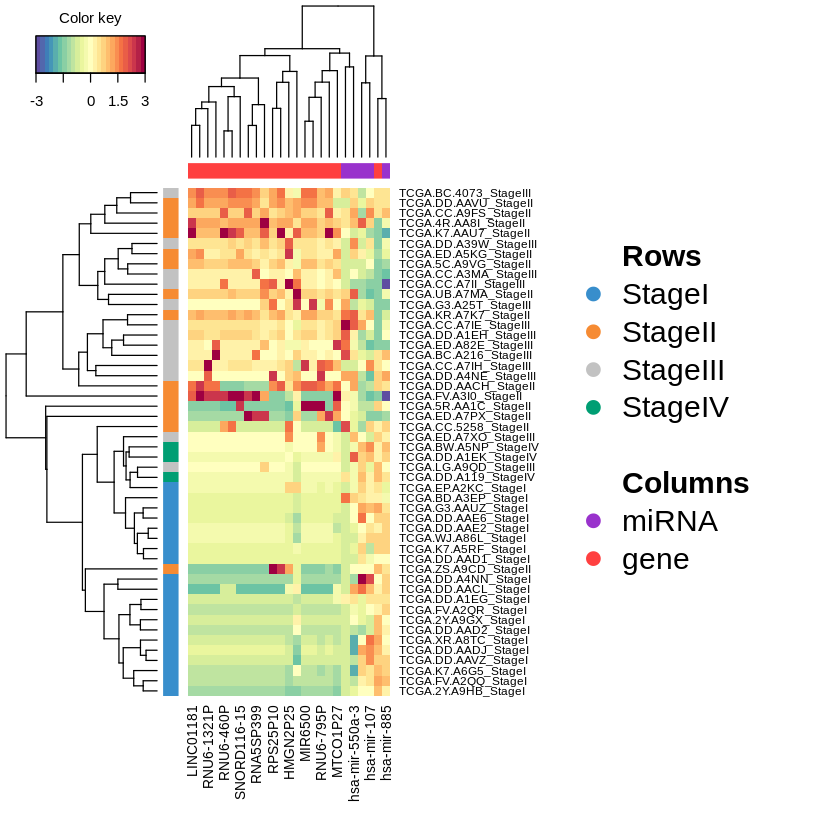

In [ ]:
cimDiablo(sgccda.res, color.blocks = c('darkorchid', 'brown1'),
          comp = 1, margin=c(8,25),  legend.position = "right")

# **Performance of the model**
We assess the performance of the model using 3-fold cross-validation repeated 10 times with the
function perf. The method runs a block.splsda model on the pre-specified arguments input from
our sgccda.res object but on cross-validated samples. We then assess the accuracy of the prediction
on the left out samples.

In [ ]:
set.seed(123)
perf.diablo <- perf(
  sgccda.res,
  validation = "Mfold",
  folds = 3,
  nrepeat = 10,
  dist = "centroids.dist",
  BPPARAM = SerialParam()  # or MulticoreParam(workers = 2L)
)


## **ERROR Rate**

In [ ]:
# Performance with Majority vote
perf.diablo$MajorityVote.error.rate

# Performance with Weighted vote
perf.diablo$WeightedVote.error.rate

,comp1,comp2,comp3,comp4,comp5
StageI,0.8050000,0.7600000,0.5050000,0.4900000,0.5100000
StageII,0.9214286,0.9714286,0.9571429,0.9357143,0.9357143
StageIII,0.8769231,0.9230769,0.8923077,0.8769231,0.8692308
StageIV,0.9666667,0.8666667,1.0000000,1.0000000,1.0000000
Overall.ER,0.8660000,0.8680000,0.7620000,0.7460000,0.7520000
Overall.BER,0.8925046,0.8802930,0.8386126,0.8256593,0.8287363


,comp1,comp2,comp3,comp4,comp5
StageI,0.4350000,0.3650000,0.1450000,0.1550000,0.1500000
StageII,0.7571429,0.8714286,0.8500000,0.8214286,0.8214286
StageIII,0.5615385,0.6153846,0.5076923,0.4538462,0.4692308
StageIV,0.4333333,0.4333333,1.0000000,1.0000000,1.0000000
Overall.ER,0.5580000,0.5760000,0.4880000,0.4700000,0.4720000
Overall.BER,0.5467537,0.5712866,0.6256731,0.6075687,0.6101648


## **AUC plot**
An AUC plot per block is plotted using the function auroc, such output as the ROC and AUC criteria are not particularly insightful in relation
to the performance evaluation of our methods, but can complement the statistical analysis.

$miRNA
$miRNA$comp1
                        AUC   p-value
StageI vs Other(s)   0.8583 2.066e-05
StageII vs Other(s)  0.7579 4.971e-03
StageIII vs Other(s) 0.7775 3.150e-03
StageIV vs Other(s)  0.8440 4.756e-02

$miRNA$comp2
                        AUC   p-value
StageI vs Other(s)   0.8667 1.321e-05
StageII vs Other(s)  0.9048 1.044e-05
StageIII vs Other(s) 0.9085 1.386e-05
StageIV vs Other(s)  0.8723 3.198e-02

$miRNA$comp3
                        AUC   p-value
StageI vs Other(s)   0.8983 2.213e-06
StageII vs Other(s)  0.9048 1.044e-05
StageIII vs Other(s) 0.9002 2.066e-05
StageIV vs Other(s)  0.9645 7.457e-03

$miRNA$comp4
                        AUC   p-value
StageI vs Other(s)   0.9033 1.649e-06
StageII vs Other(s)  0.9365 1.999e-06
StageIII vs Other(s) 0.9189 8.325e-06
StageIV vs Other(s)  0.9716 6.597e-03

$miRNA$comp5
                        AUC   p-value
StageI vs Other(s)   0.9483 9.985e-08
StageII vs Other(s)  0.9325 2.474e-06
StageIII vs Other(s) 0.9418 2.602e-06
StageIV vs O

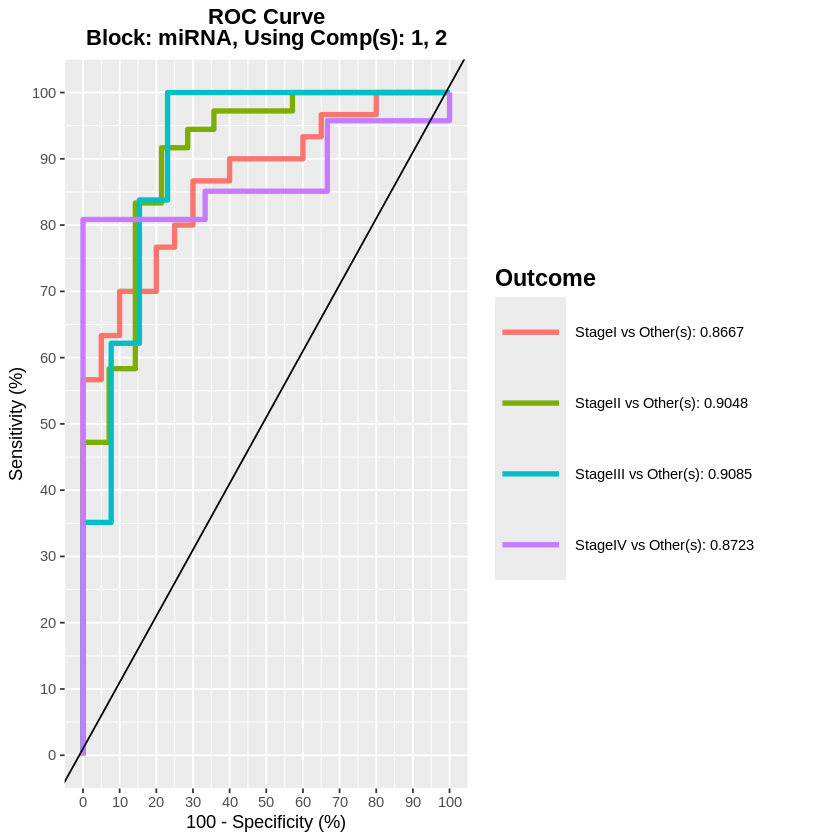

In [ ]:
auc.diablo = auroc(sgccda.res, roc.block = "miRNA", roc.comp = 2)

$miRNA
$miRNA$comp1
                        AUC   p-value
StageI vs Other(s)   0.8583 2.066e-05
StageII vs Other(s)  0.7579 4.971e-03
StageIII vs Other(s) 0.7775 3.150e-03
StageIV vs Other(s)  0.8440 4.756e-02

$miRNA$comp2
                        AUC   p-value
StageI vs Other(s)   0.8667 1.321e-05
StageII vs Other(s)  0.9048 1.044e-05
StageIII vs Other(s) 0.9085 1.386e-05
StageIV vs Other(s)  0.8723 3.198e-02

$miRNA$comp3
                        AUC   p-value
StageI vs Other(s)   0.8983 2.213e-06
StageII vs Other(s)  0.9048 1.044e-05
StageIII vs Other(s) 0.9002 2.066e-05
StageIV vs Other(s)  0.9645 7.457e-03

$miRNA$comp4
                        AUC   p-value
StageI vs Other(s)   0.9033 1.649e-06
StageII vs Other(s)  0.9365 1.999e-06
StageIII vs Other(s) 0.9189 8.325e-06
StageIV vs Other(s)  0.9716 6.597e-03

$miRNA$comp5
                        AUC   p-value
StageI vs Other(s)   0.9483 9.985e-08
StageII vs Other(s)  0.9325 2.474e-06
StageIII vs Other(s) 0.9418 2.602e-06
StageIV vs O

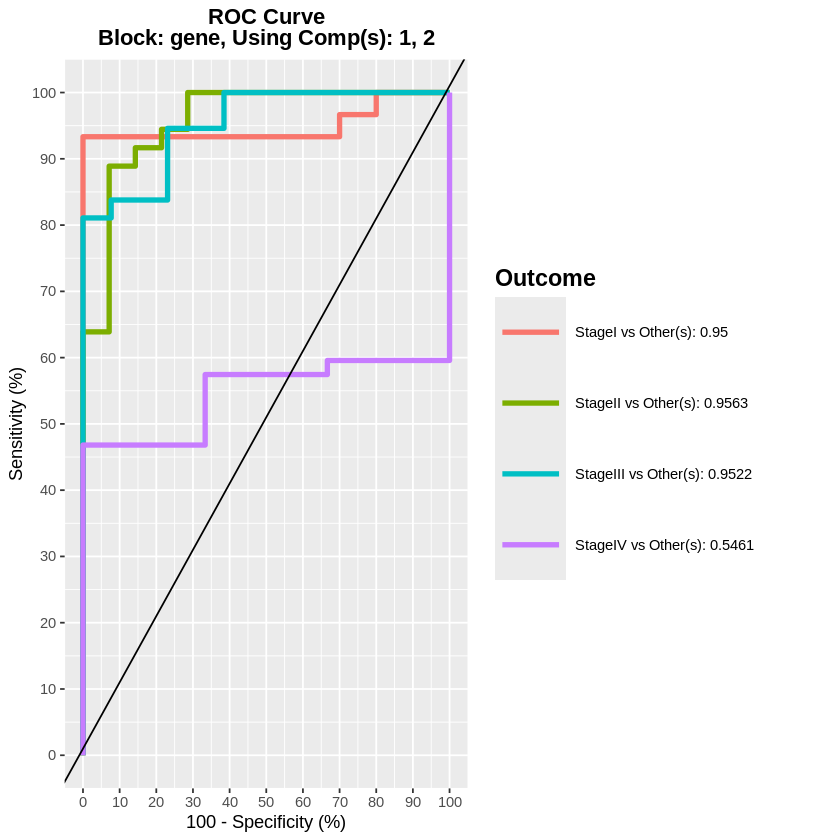

In [ ]:
auc.diablo = auroc(sgccda.res, roc.block = "gene", roc.comp = 2)